## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [1]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [2]:
## TODO: Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from models import Net, weight_init

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4_drop): Dropout2d(p=0.4)
  (fc1): Linear(in_features=50176, out_features=2560, bias=True)
  (fc2): Linear(in_features=2560, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=136, bias=True)
  (fc1_drop): Dropout(p=0.5)
  (fc2_drop): Dropout(p=0.6)
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, aff

In [3]:
# download net into GPU if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

net = net.to(device)

cuda


## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(250),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [5]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                             root_dir='data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [6]:
# load training data in batches
batch_size = 40

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [7]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='data/test_frames_keypoints.csv',
                                             root_dir='data/test/',
                                             transform=data_transform)



In [8]:
# load test data in batches
test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Make sure the image is a FloatTensor, which the model expects.
3. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [9]:
# test the model on a batch of test images

def net_sample_output():
    # switch to eval mode
    net.eval()
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints'].to(device)

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)
        images = images.to(device)
        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [10]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([40, 1, 224, 224])
torch.Size([40, 68, 2])
torch.Size([40, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [11]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

/home/randomwalk10/anaconda3/envs/cv-nd/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


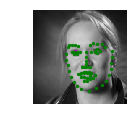

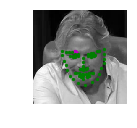

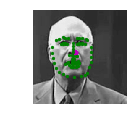

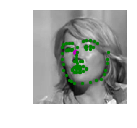

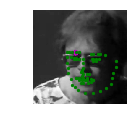

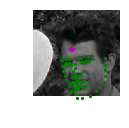

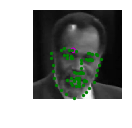

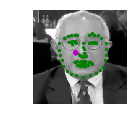

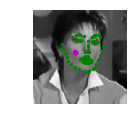

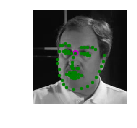

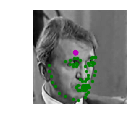

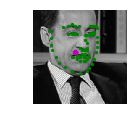

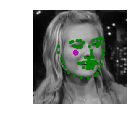

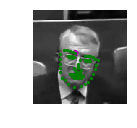

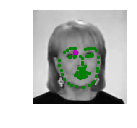

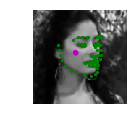

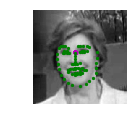

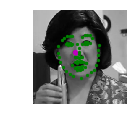

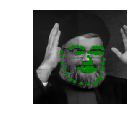

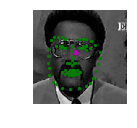

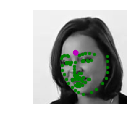

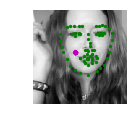

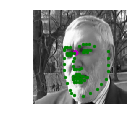

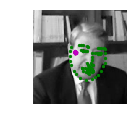

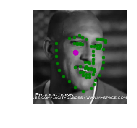

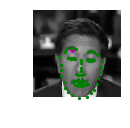

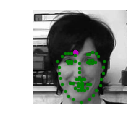

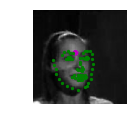

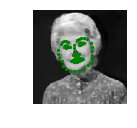

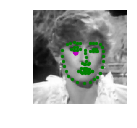

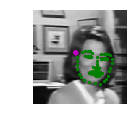

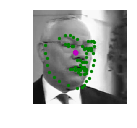

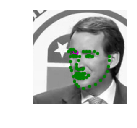

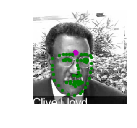

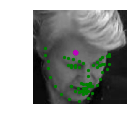

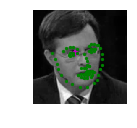

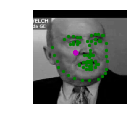

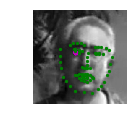

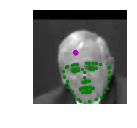

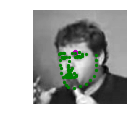

In [12]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):
    
    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(5, batch_size/5, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images.cpu(), test_outputs.cpu(), gt_pts.cpu(), batch_size)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [13]:
## TODO: Define the loss and optimization
import torch.optim as optim

# criterion = nn.L1Loss()
criterion = nn.MSELoss()

optimizer = optim.SGD(net.parameters(), lr = 0.02, momentum=0.9)
# optimizer = optim.Adam(net.parameters(), lr = 0.01)

## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [14]:
def train_net(n_epochs):    
    # prepare the net for training
    net.train()
    
    # list of epoch loss
    list_epoch_loss = []

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0
        
        epoch_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)
            
            # download variables to device
            images = images.to(device)
            key_pts = key_pts.to(device)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to the running_loss, use .item()
            running_loss += loss.item()
            epoch_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                running_loss /= (10*batch_size)
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss))
                running_loss = 0.0
                
        # append epoch loss to list
        list_epoch_loss.append(epoch_loss/(batch_size*len(train_loader)))

    print('Finished Training')
    
    return list_epoch_loss


In [15]:
# train your network
n_epochs = 200 # start small, and increase when you've decided on your model structure and hyperparams

# training is faster without weight initialization
# net.apply(weight_init) # init weights
list_epoch_loss = train_net(n_epochs)

Epoch: 1, Batch: 10, Avg. Loss: 0.01365838885307312
Epoch: 1, Batch: 20, Avg. Loss: 0.007800888866186142
Epoch: 1, Batch: 30, Avg. Loss: 0.0065027203783392905
Epoch: 1, Batch: 40, Avg. Loss: 0.005516553372144699
Epoch: 1, Batch: 50, Avg. Loss: 0.004947558790445328
Epoch: 1, Batch: 60, Avg. Loss: 0.005092066936194897
Epoch: 1, Batch: 70, Avg. Loss: 0.005451279915869236
Epoch: 1, Batch: 80, Avg. Loss: 0.004518787674605847
Epoch: 2, Batch: 10, Avg. Loss: 0.005279870666563511
Epoch: 2, Batch: 20, Avg. Loss: 0.005369303785264492
Epoch: 2, Batch: 30, Avg. Loss: 0.004924668855965137
Epoch: 2, Batch: 40, Avg. Loss: 0.004817091561853885
Epoch: 2, Batch: 50, Avg. Loss: 0.00417576402425766
Epoch: 2, Batch: 60, Avg. Loss: 0.00461735799908638
Epoch: 2, Batch: 70, Avg. Loss: 0.00607462003827095
Epoch: 2, Batch: 80, Avg. Loss: 0.004302750546485185
Epoch: 3, Batch: 10, Avg. Loss: 0.004745522774755955
Epoch: 3, Batch: 20, Avg. Loss: 0.004511317647993565
Epoch: 3, Batch: 30, Avg. Loss: 0.003974785245954

Epoch: 20, Batch: 10, Avg. Loss: 0.0011435877811163664
Epoch: 20, Batch: 20, Avg. Loss: 0.0014937472203746438
Epoch: 20, Batch: 30, Avg. Loss: 0.0012567182164639234
Epoch: 20, Batch: 40, Avg. Loss: 0.001085176570340991
Epoch: 20, Batch: 50, Avg. Loss: 0.0010892148595303297
Epoch: 20, Batch: 60, Avg. Loss: 0.0014153858460485935
Epoch: 20, Batch: 70, Avg. Loss: 0.0012002147547900677
Epoch: 20, Batch: 80, Avg. Loss: 0.0015660590771585702
Epoch: 21, Batch: 10, Avg. Loss: 0.0009557618387043476
Epoch: 21, Batch: 20, Avg. Loss: 0.001764931483194232
Epoch: 21, Batch: 30, Avg. Loss: 0.0009621913032606244
Epoch: 21, Batch: 40, Avg. Loss: 0.0010943310894072056
Epoch: 21, Batch: 50, Avg. Loss: 0.0010133031010627746
Epoch: 21, Batch: 60, Avg. Loss: 0.0010830995254218578
Epoch: 21, Batch: 70, Avg. Loss: 0.0009968395484611392
Epoch: 21, Batch: 80, Avg. Loss: 0.0010477266740053892
Epoch: 22, Batch: 10, Avg. Loss: 0.001282556876540184
Epoch: 22, Batch: 20, Avg. Loss: 0.001018938459455967
Epoch: 22, Bat

Epoch: 38, Batch: 70, Avg. Loss: 0.0008712742151692509
Epoch: 38, Batch: 80, Avg. Loss: 0.0007616058783605694
Epoch: 39, Batch: 10, Avg. Loss: 0.0007241308409720659
Epoch: 39, Batch: 20, Avg. Loss: 0.001466538575477898
Epoch: 39, Batch: 30, Avg. Loss: 0.0007651107152923942
Epoch: 39, Batch: 40, Avg. Loss: 0.0007274294178932905
Epoch: 39, Batch: 50, Avg. Loss: 0.0012532402761280537
Epoch: 39, Batch: 60, Avg. Loss: 0.0007572676474228501
Epoch: 39, Batch: 70, Avg. Loss: 0.0011938632233068347
Epoch: 39, Batch: 80, Avg. Loss: 0.0011444565188139678
Epoch: 40, Batch: 10, Avg. Loss: 0.000998216150328517
Epoch: 40, Batch: 20, Avg. Loss: 0.000818590191192925
Epoch: 40, Batch: 30, Avg. Loss: 0.0008412166638299823
Epoch: 40, Batch: 40, Avg. Loss: 0.0007385467039421201
Epoch: 40, Batch: 50, Avg. Loss: 0.0008009479241445661
Epoch: 40, Batch: 60, Avg. Loss: 0.000984443798661232
Epoch: 40, Batch: 70, Avg. Loss: 0.0008474631560966373
Epoch: 40, Batch: 80, Avg. Loss: 0.000932616456411779
Epoch: 41, Batc

Epoch: 57, Batch: 50, Avg. Loss: 0.0005736604845151305
Epoch: 57, Batch: 60, Avg. Loss: 0.0006120597524568439
Epoch: 57, Batch: 70, Avg. Loss: 0.0007725358288735152
Epoch: 57, Batch: 80, Avg. Loss: 0.0005366278020665049
Epoch: 58, Batch: 10, Avg. Loss: 0.0005157293379306794
Epoch: 58, Batch: 20, Avg. Loss: 0.000641815229319036
Epoch: 58, Batch: 30, Avg. Loss: 0.0005628493381664157
Epoch: 58, Batch: 40, Avg. Loss: 0.0007262699399143458
Epoch: 58, Batch: 50, Avg. Loss: 0.0005806458368897438
Epoch: 58, Batch: 60, Avg. Loss: 0.0005687684053555131
Epoch: 58, Batch: 70, Avg. Loss: 0.0011390771623700858
Epoch: 58, Batch: 80, Avg. Loss: 0.0006329713761806488
Epoch: 59, Batch: 10, Avg. Loss: 0.0008237006887793541
Epoch: 59, Batch: 20, Avg. Loss: 0.0005811545066535473
Epoch: 59, Batch: 30, Avg. Loss: 0.0005994271114468574
Epoch: 59, Batch: 40, Avg. Loss: 0.0006808243924751878
Epoch: 59, Batch: 50, Avg. Loss: 0.0006385697610676289
Epoch: 59, Batch: 60, Avg. Loss: 0.0006330189621075988
Epoch: 59, 

Epoch: 76, Batch: 30, Avg. Loss: 0.0005854600528255105
Epoch: 76, Batch: 40, Avg. Loss: 0.0006310412916354835
Epoch: 76, Batch: 50, Avg. Loss: 0.0007775094383396208
Epoch: 76, Batch: 60, Avg. Loss: 0.0009127240022644401
Epoch: 76, Batch: 70, Avg. Loss: 0.0006457859324291348
Epoch: 76, Batch: 80, Avg. Loss: 0.0005122044449672103
Epoch: 77, Batch: 10, Avg. Loss: 0.0007547165546566248
Epoch: 77, Batch: 20, Avg. Loss: 0.0006078897975385189
Epoch: 77, Batch: 30, Avg. Loss: 0.0005190896801650525
Epoch: 77, Batch: 40, Avg. Loss: 0.0006562826037406921
Epoch: 77, Batch: 50, Avg. Loss: 0.0005531776254065335
Epoch: 77, Batch: 60, Avg. Loss: 0.0005360677349381149
Epoch: 77, Batch: 70, Avg. Loss: 0.0005627161636948586
Epoch: 77, Batch: 80, Avg. Loss: 0.0005335552524775266
Epoch: 78, Batch: 10, Avg. Loss: 0.0005041374173015357
Epoch: 78, Batch: 20, Avg. Loss: 0.0005000744201242923
Epoch: 78, Batch: 30, Avg. Loss: 0.0005849030427634716
Epoch: 78, Batch: 40, Avg. Loss: 0.00057354302611202
Epoch: 78, B

Epoch: 95, Batch: 10, Avg. Loss: 0.0006059846887364983
Epoch: 95, Batch: 20, Avg. Loss: 0.0004996933741495014
Epoch: 95, Batch: 30, Avg. Loss: 0.0005786973075009882
Epoch: 95, Batch: 40, Avg. Loss: 0.00046604118309915063
Epoch: 95, Batch: 50, Avg. Loss: 0.0004238996049389243
Epoch: 95, Batch: 60, Avg. Loss: 0.0004144060658290982
Epoch: 95, Batch: 70, Avg. Loss: 0.0005103464401327074
Epoch: 95, Batch: 80, Avg. Loss: 0.0004638375202193856
Epoch: 96, Batch: 10, Avg. Loss: 0.0004980068537406623
Epoch: 96, Batch: 20, Avg. Loss: 0.0005043387459591031
Epoch: 96, Batch: 30, Avg. Loss: 0.0004941580770537257
Epoch: 96, Batch: 40, Avg. Loss: 0.0005475707654841244
Epoch: 96, Batch: 50, Avg. Loss: 0.0004938353411853314
Epoch: 96, Batch: 60, Avg. Loss: 0.0005593692790716886
Epoch: 96, Batch: 70, Avg. Loss: 0.0005355700897052884
Epoch: 96, Batch: 80, Avg. Loss: 0.00043937331764027477
Epoch: 97, Batch: 10, Avg. Loss: 0.0005329510709270835
Epoch: 97, Batch: 20, Avg. Loss: 0.00047536479542031884
Epoch: 

Epoch: 113, Batch: 40, Avg. Loss: 0.00044300112873315814
Epoch: 113, Batch: 50, Avg. Loss: 0.0005269026802852749
Epoch: 113, Batch: 60, Avg. Loss: 0.0004422431951388717
Epoch: 113, Batch: 70, Avg. Loss: 0.00048527587670832873
Epoch: 113, Batch: 80, Avg. Loss: 0.00044293385464698075
Epoch: 114, Batch: 10, Avg. Loss: 0.0004283129284158349
Epoch: 114, Batch: 20, Avg. Loss: 0.00045795175479725005
Epoch: 114, Batch: 30, Avg. Loss: 0.00041963922092691063
Epoch: 114, Batch: 40, Avg. Loss: 0.0004066504002548754
Epoch: 114, Batch: 50, Avg. Loss: 0.00039579991018399594
Epoch: 114, Batch: 60, Avg. Loss: 0.0004044894524849951
Epoch: 114, Batch: 70, Avg. Loss: 0.00039353875676169993
Epoch: 114, Batch: 80, Avg. Loss: 0.0004294487345032394
Epoch: 115, Batch: 10, Avg. Loss: 0.0004691640567034483
Epoch: 115, Batch: 20, Avg. Loss: 0.00044603789690881966
Epoch: 115, Batch: 30, Avg. Loss: 0.0004469425417482853
Epoch: 115, Batch: 40, Avg. Loss: 0.00041299242759123444
Epoch: 115, Batch: 50, Avg. Loss: 0.000

Epoch: 131, Batch: 60, Avg. Loss: 0.00039152212208136915
Epoch: 131, Batch: 70, Avg. Loss: 0.0004326210729777813
Epoch: 131, Batch: 80, Avg. Loss: 0.0004390972782857716
Epoch: 132, Batch: 10, Avg. Loss: 0.00039940425660461187
Epoch: 132, Batch: 20, Avg. Loss: 0.0003795029129832983
Epoch: 132, Batch: 30, Avg. Loss: 0.0004451181436888874
Epoch: 132, Batch: 40, Avg. Loss: 0.00038017056649550793
Epoch: 132, Batch: 50, Avg. Loss: 0.00041348000522702935
Epoch: 132, Batch: 60, Avg. Loss: 0.00044751101871952413
Epoch: 132, Batch: 70, Avg. Loss: 0.0003810190735384822
Epoch: 132, Batch: 80, Avg. Loss: 0.00039149098098278045
Epoch: 133, Batch: 10, Avg. Loss: 0.0003616453404538333
Epoch: 133, Batch: 20, Avg. Loss: 0.0004258620273321867
Epoch: 133, Batch: 30, Avg. Loss: 0.00037721223197877406
Epoch: 133, Batch: 40, Avg. Loss: 0.0008168673794716597
Epoch: 133, Batch: 50, Avg. Loss: 0.00046005859971046445
Epoch: 133, Batch: 60, Avg. Loss: 0.00044282396556809543
Epoch: 133, Batch: 70, Avg. Loss: 0.000

Epoch: 149, Batch: 80, Avg. Loss: 0.0003833808656781912
Epoch: 150, Batch: 10, Avg. Loss: 0.000433540609665215
Epoch: 150, Batch: 20, Avg. Loss: 0.00034692160552367567
Epoch: 150, Batch: 30, Avg. Loss: 0.00036016646539792417
Epoch: 150, Batch: 40, Avg. Loss: 0.000394867246504873
Epoch: 150, Batch: 50, Avg. Loss: 0.0003510973253287375
Epoch: 150, Batch: 60, Avg. Loss: 0.00036846812814474107
Epoch: 150, Batch: 70, Avg. Loss: 0.0004926477093249559
Epoch: 150, Batch: 80, Avg. Loss: 0.0003715056832879782
Epoch: 151, Batch: 10, Avg. Loss: 0.0003904417436569929
Epoch: 151, Batch: 20, Avg. Loss: 0.0004100777045823634
Epoch: 151, Batch: 30, Avg. Loss: 0.0004144494398497045
Epoch: 151, Batch: 40, Avg. Loss: 0.0003541603125631809
Epoch: 151, Batch: 50, Avg. Loss: 0.00039030139800161123
Epoch: 151, Batch: 60, Avg. Loss: 0.00033243201440200207
Epoch: 151, Batch: 70, Avg. Loss: 0.00036454855464398864
Epoch: 151, Batch: 80, Avg. Loss: 0.0004002246423624456
Epoch: 152, Batch: 10, Avg. Loss: 0.00037230

Epoch: 168, Batch: 20, Avg. Loss: 0.0003297201707027853
Epoch: 168, Batch: 30, Avg. Loss: 0.00037194665521383285
Epoch: 168, Batch: 40, Avg. Loss: 0.0004589769756421447
Epoch: 168, Batch: 50, Avg. Loss: 0.0003327390947379172
Epoch: 168, Batch: 60, Avg. Loss: 0.00042848467594012616
Epoch: 168, Batch: 70, Avg. Loss: 0.0003289586561731994
Epoch: 168, Batch: 80, Avg. Loss: 0.00033189393114298584
Epoch: 169, Batch: 10, Avg. Loss: 0.00036068779416382313
Epoch: 169, Batch: 20, Avg. Loss: 0.000361935687251389
Epoch: 169, Batch: 30, Avg. Loss: 0.0003618171298876405
Epoch: 169, Batch: 40, Avg. Loss: 0.00033190540038049223
Epoch: 169, Batch: 50, Avg. Loss: 0.0003651987505145371
Epoch: 169, Batch: 60, Avg. Loss: 0.00035312731051817536
Epoch: 169, Batch: 70, Avg. Loss: 0.0003343449649401009
Epoch: 169, Batch: 80, Avg. Loss: 0.00035288082668557765
Epoch: 170, Batch: 10, Avg. Loss: 0.000338201723061502
Epoch: 170, Batch: 20, Avg. Loss: 0.00037042290903627873
Epoch: 170, Batch: 30, Avg. Loss: 0.000370

Epoch: 186, Batch: 40, Avg. Loss: 0.00033668739255517723
Epoch: 186, Batch: 50, Avg. Loss: 0.0003116206801496446
Epoch: 186, Batch: 60, Avg. Loss: 0.00031218877760693433
Epoch: 186, Batch: 70, Avg. Loss: 0.0003381712827831507
Epoch: 186, Batch: 80, Avg. Loss: 0.000353095477912575
Epoch: 187, Batch: 10, Avg. Loss: 0.0002940816548652947
Epoch: 187, Batch: 20, Avg. Loss: 0.00032594760647043587
Epoch: 187, Batch: 30, Avg. Loss: 0.0003153201378881931
Epoch: 187, Batch: 40, Avg. Loss: 0.0003448204859159887
Epoch: 187, Batch: 50, Avg. Loss: 0.0003846475365571678
Epoch: 187, Batch: 60, Avg. Loss: 0.0003047784394584596
Epoch: 187, Batch: 70, Avg. Loss: 0.00030281971907243133
Epoch: 187, Batch: 80, Avg. Loss: 0.0003029811312444508
Epoch: 188, Batch: 10, Avg. Loss: 0.0003389602340757847
Epoch: 188, Batch: 20, Avg. Loss: 0.0005031573795713485
Epoch: 188, Batch: 30, Avg. Loss: 0.0003906039125286043
Epoch: 188, Batch: 40, Avg. Loss: 0.0003640409582294524
Epoch: 188, Batch: 50, Avg. Loss: 0.000327783

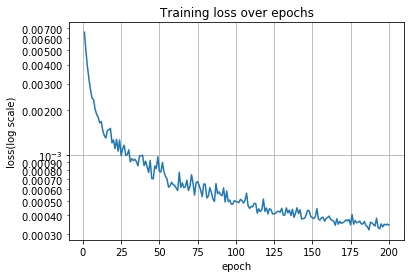

In [16]:
# plot loss over epoch
# Data for plotting
t = np.arange(1, 1+len(list_epoch_loss), 1)
fig, ax = plt.subplots()
plt.yscale('logit')
ax.plot(t, list_epoch_loss)

ax.set(xlabel='epoch', ylabel='loss(log scale)',
       title='Training loss over epochs')
ax.grid()

plt.show()

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [17]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([40, 1, 224, 224])
torch.Size([40, 68, 2])
torch.Size([40, 68, 2])


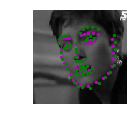

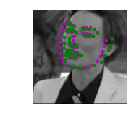

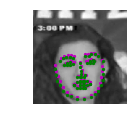

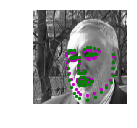

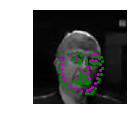

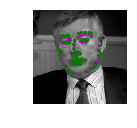

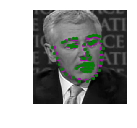

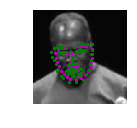

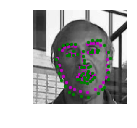

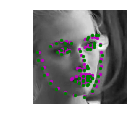

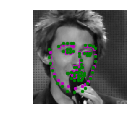

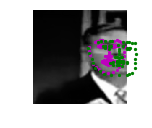

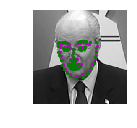

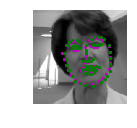

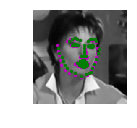

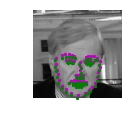

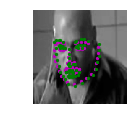

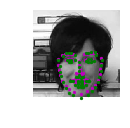

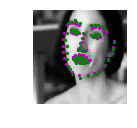

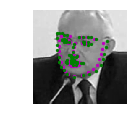

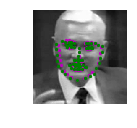

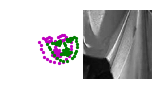

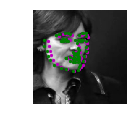

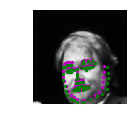

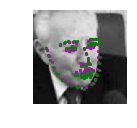

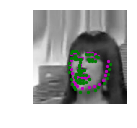

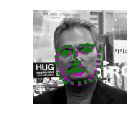

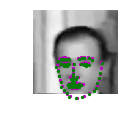

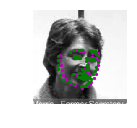

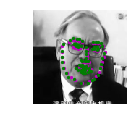

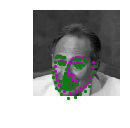

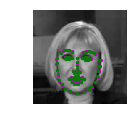

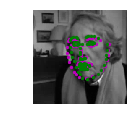

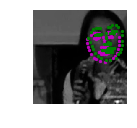

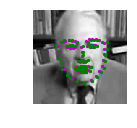

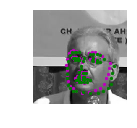

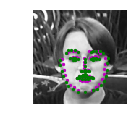

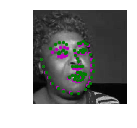

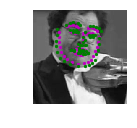

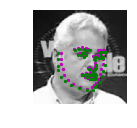

In [18]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images.cpu(), test_outputs.cpu(), gt_pts.cpu(), batch_size)


Once you've found a good model (or two), save your model so you can load it and use it later!

In [19]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model_20190422.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**:

Stochastic Gradient Descent(SGD) is chosen as the optimizer because:

- It is fast in training the network.
- It is simple to implement and robust in real application.

Mean Squared Error(MSE) is chosen as the loss function because:

- MSE is commonly used in regression applications as the loss function.
- The L2 norm accelerates the weight updating on parts of network that account for bigger losses.

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**:

I start with a architecture similar with the one proposed in [this paper](https://arxiv.org/pdf/1710.00977.pdf).

It is like:
    
    (Conv2D->RELU->Maxpooling->Dropout2D)*4 -> (FCL->RELU->Dropout)*2 -> FCL.
    
Where all the four Conv2D have a 3x3 kernel with stride 1 and padding 1, the dropout ratio increases from 0.1 to 0.6 as the layer gets deeper.

It works but the drawback is that a large number of epochs is needed in order to produce a decent result.

In order to reduce the training time. Three Batch Normalization(BN) layers are inserted into the first three convolutional layers with their dropout layers removed. The final architecture is like:

    (Conv2D->BN2D->RELU->Maxpooling)*3 -> (Conv2D->RELU->Maxpooling->Dropout2D) -> (FCL->RELU->Dropout)*2 -> FCL.
    
This new archtecture saves the training time by half and produce the same decent result.

There is no need to add more convolutional layers or any layers to avoid overfitting the data since dropout layers are aggressively used in this case.

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**:

Basically I start with a small number of epochs and gradually increase it until the model stops to improve.

A larger batch_size will help to speed up the training of model but on the other hand consume more memory. I have a 1080 ti installed on my local machine so I choose a large batch_size in this case.

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

[[-0.34627178  0.21940361  0.35205865]
 [-0.13345772 -0.21897711  0.27193284]
 [-0.32381329 -0.04981171  0.22730736]]
(3, 3)


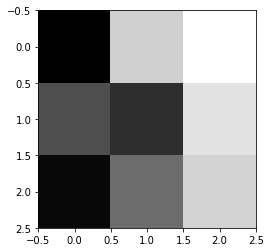

In [20]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.cpu().numpy()

filter_index = 3

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

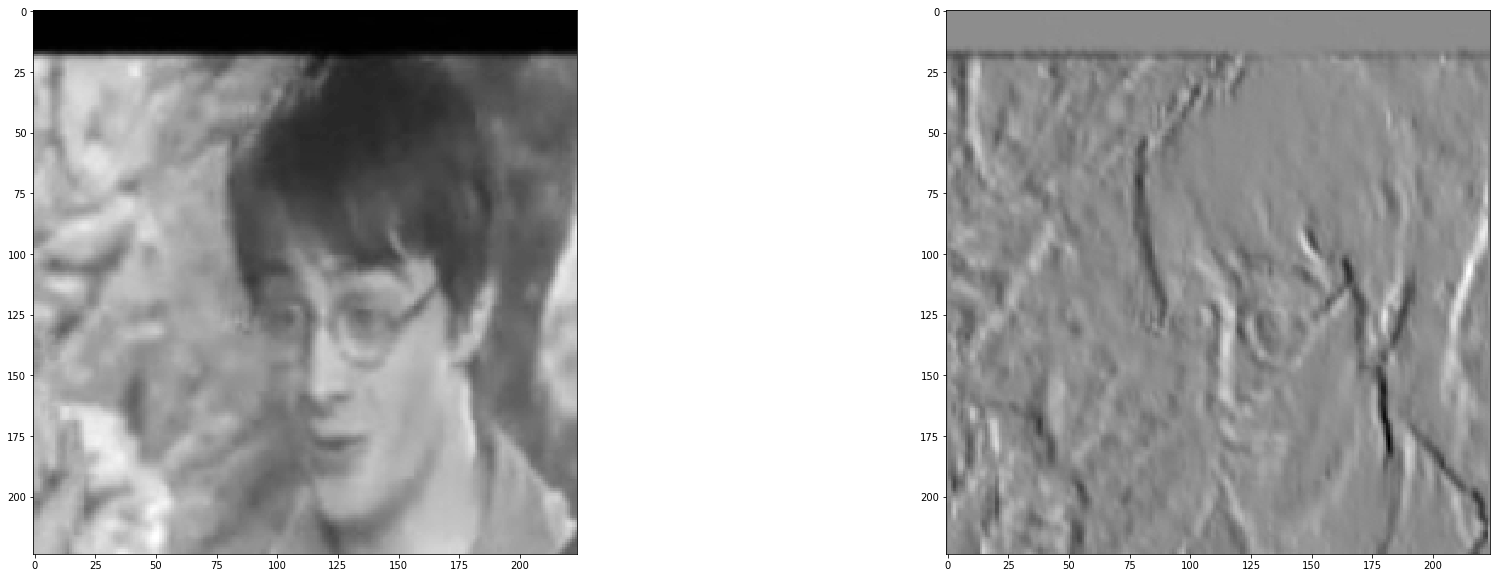

In [21]:
##TODO: load in and display any image from the transformed test dataset
# obtain one batch of testing images
dataiter = iter(test_loader)
images = dataiter.next()['image'].numpy()

# select image by index
idx = 0
img = np.squeeze(images[idx])

# display the original image on the left side
import cv2

fig=plt.figure(figsize=(30, 10))
fig.add_subplot(1, 2, 1)
plt.imshow(img, cmap='gray')

## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image
c = cv2.filter2D(img, -1, np.squeeze(w[filter_index])) # filtered image
fig.add_subplot(1, 2, 2)
plt.imshow(c, cmap='gray')

plt.show()

### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**:

I test the filter with index 3 in the first convolutional layer. It calculates the value difference of pixels in the upper right against those in the lower left in a kernel. This detects features of gradients pointing from lower left to upper right. 

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!